# Exploratory data analysis of Voyager magnetic field time series

Aiming to reproduce a particularly messy structure function in FraternaleEA (2019):

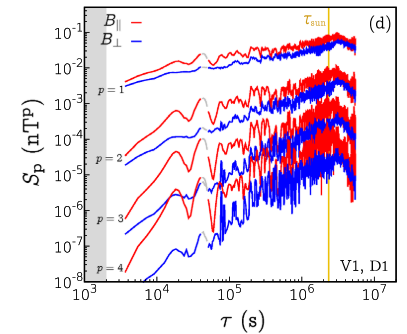

Power-laws $\zeta_p$ in Table 4 (alongside $p/3$ predictions) were fitted to the range $\tau\subset[10^4,2\times10^5]$ *seems ambitious for such a messy sf*

See Fig. 5(d) below for the power spectrum and metadata. Note that this power spectra was built using the technique they developed of compressed sensing, as well as linear interpolation + BT-method for $f<10^{-5}$


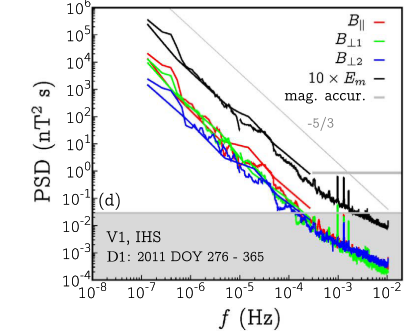

In [134]:
import numpy as np
import pandas as pd
import cdflib
import math as m
import seaborn as sns
import os
import importlib
from scipy import signal
from matplotlib import pyplot as plt
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from scipy import fft

# while ".toplevel" not in os.listdir():
#     os.chdir("..")

from src.data_import_funcs import read_cdfs, date_1d_dict, read_asc_ts
import src.utils as utils

# Set matplotlib font size
plt.rcParams.update({"font.size": 14})

## What does a CDF file contents look like?

In [2]:
cdf_file = cdflib.CDF("data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf")

In [3]:
print(cdf_file.globalattsget(expand=False))

{'TITLE': 'VOYAGER1', 'Project': 'VOYAGER1', 'Discipline': ['Space Physics>Interplanetary Studies', 'Solar Physics>Heliospheric Physics'], 'Source_name': 'VOYAGER1> Voyager 1', 'Data_type': '48SEC>48 second Time Resolution', 'Descriptor': 'VIM>Magnetic Field VIM', 'Data_version': '1', 'TEXT': ['The  main science objectives for the VOYAGER interplanetary mission are as   follows: ', '- investigate the structure of the solar wind magnetic fields and plasma in the inner and outer heliosphere; ', '- conduct long term study of heliospheric evolution during different phases of the twenty-two year solar magnetic cycle and the eleven-year solar activity cycle;', '- study the long term solar modulation and determine the elemental and isotopic abundances of galactic cosmic ray particles in the heliosphere;', '- measure  radial gradients, spectra, and nuclear abundances of the anomalous component of cosmic rays  from  acceleration at the solar wind termination shock; ', '- investigate local parti

In [4]:
# Full data structure
print(cdf_file.cdf_info())

{'CDF': WindowsPath('C:/Users/spann/Documents/Research/Code repos/time_series_analysis/data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf'), 'Version': '3.6.1', 'Encoding': 1, 'Majority': 'Column_major', 'rVariables': [], 'zVariables': ['Epoch', 'Epoch_ephem', 'spacecraftID', 'F1', 'BR', 'BT', 'BN', 'dF', 'dBR', 'dBT', 'dBN', 'Radius', 'hg_lat', 'hg_lon', 'hgi_lon'], 'Attributes': [{'TITLE': 'Global'}, {'Project': 'Global'}, {'Discipline': 'Global'}, {'Source_name': 'Global'}, {'Data_type': 'Global'}, {'Descriptor': 'Global'}, {'Data_version': 'Global'}, {'Generated_by': 'Global'}, {'Generation_date': 'Global'}, {'TEXT': 'Global'}, {'MODS': 'Global'}, {'ADID_ref': 'Global'}, {'Logical_file_id': 'Global'}, {'Logical_source': 'Global'}, {'Logical_source_description': 'Global'}, {'PI_name': 'Global'}, {'PI_affiliation': 'Global'}, {'Mission_group': 'Global'}, {'Instrument_type': 'Global'}, {'Time_resolution': 'Global'}, {'Web_site': 'Global'}, {'Acknowledgement': 'Global'}, {'Rules_of

In [5]:
# Variable names - zVariables are variables that can have dimensionalities that are different than those of the rVariables (and each other).
print(cdf_file.cdf_info()["zVariables"])

['Epoch', 'Epoch_ephem', 'spacecraftID', 'F1', 'BR', 'BT', 'BN', 'dF', 'dBR', 'dBT', 'dBN', 'Radius', 'hg_lat', 'hg_lon', 'hgi_lon']


In [6]:
# Looking at single variable
print(cdf_file.varinq("F1"))  # basic variable information

{'Variable': 'F1', 'Num': 3, 'Var_Type': 'zVariable', 'Data_Type': 21, 'Data_Type_Description': 'CDF_REAL4', 'Num_Elements': 1, 'Num_Dims': 0, 'Dim_Sizes': [], 'Sparse': 'No_sparse', 'Last_Rec': 199939, 'Rec_Vary': True, 'Dim_Vary': [], 'Pad': array([0.], dtype=float32), 'Compress': 0, 'Block_Factor': 0}


In [7]:
print(cdf_file.varattsget("BR"))  # variable attributes

{'FIELDNAM': 'BR in RTN', 'CATDESC': 'BR in RTN (Radial-Tangential-Normal) coordinate system (w/ uncertainty)', 'VALIDMIN': -10.0, 'VALIDMAX': 10.0, 'UNITS': 'nT', 'FORMAT': 'f10.5', 'VAR_TYPE': 'data', 'FILLVAL': -1e+31, 'DEPEND_0': 'Epoch', 'LABLAXIS': 'Voyager1_BR', 'DISPLAY_TYPE': 'time_series'}


In [8]:
print(cdf_file.varattsget("Epoch"))  # variable attributes

{'FIELDNAM': 'Time', 'CATDESC': 'Time, beginning of interval', 'VALIDMIN': 62987673600000.0, 'VALIDMAX': 63745056000000.0, 'SCALEMIN': 62987673600000.0, 'SCALEMAX': 63745056000000.0, 'UNITS': 'ms', 'FORMAT': 'E14.8', 'MONOTON': 'INCREASE', 'VAR_TYPE': 'support_data', 'DICT_KEY': 'time>epoch', 'FILLVAL': -1e+31, 'LABLAXIS': 'Epoch', 'AVG_TYPE': ' ', 'DISPLAY_TYPE': ' ', 'VAR_NOTES': ' ', 'SCALETYP': 'LINEAR'}


In [9]:
print(
    "Missing values for this variable are replaced with:",
    cdf_file.varattsget("BR")["FILLVAL"],
)

BR = cdf_file.varget("BR")

print("The structure of this variable is", format(type(BR)))
print("The type of data stored in this variable is", format(BR.dtype))

print(BR)

Missing values for this variable are replaced with: -1e+31
The structure of this variable is <class 'numpy.ndarray'>
The type of data stored in this variable is float32
[ 0.06866  0.06511  0.0655  ... -0.01047 -0.01163 -0.01678]


## Using adapted function from Tulasi to read in multiple CDFs at once

In [10]:
voyager1_data_raw = read_cdfs(
    [
        # "data/raw/voyager/voyager1_48s_mag-vim_20090101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20100101_v01.cdf",
        "data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20120101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20130101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20140101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20150101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20160101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20170101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20180101_v01.cdf",
        # "data/Voyager/voyager1_48s_mag-vim_20190101_v01.cdf",
    ],
    ["Epoch", "F1", "BR", "BT", "BN"],
)

reading file  data/raw/voyager/voyager1_48s_mag-vim_20110101_v01.cdf
Done reading data


In [11]:
voyager1_data = date_1d_dict(
    voyager1_data_raw, "48S"
)  # Resampling with freq means we do not get lines drawn between missing data points on line plots, however it does require some averaging which puts the time points slightly off
# voyager2_data = date_1d_dict(voyager2_data_raw, "48S")
# voyager1_data['mag_calculated'] = (voyager1_data['BR']**2 + voyager1_data['BT']**2 + voyager1_data['BN']**2)**(1/2)
# voyager1_data[voyager1_data.mag_calculated < 0.03] = np.nan
# print(voyager1_data.mag_calculated.min())
len(voyager1_data)
# len(voyager2_data)

Here is a snippet of the raw data (before re-sampling according to freq)
                              F1       BR       BT       BN
Time                                                       
2011-01-01 12:37:31.584  0.21758  0.06866  0.15611  0.13507
2011-01-01 12:38:19.968  0.22162  0.06511  0.15956  0.13923
2011-01-01 12:39:08.352  0.21891  0.06550  0.15134  0.14371
2011-01-01 12:39:55.872  0.21616  0.06289  0.15407  0.13775
2011-01-01 12:40:44.255  0.21758  0.06584  0.15295  0.14001


654641

In [12]:
def convert_angle(x):
    if x < 0:
        x += 360
    return x


voyager1_data["lambda"] = (
    voyager1_data["BT"]
    .div(voyager1_data["BR"])
    .apply(m.atan)
    .apply(m.degrees)
    .apply(convert_angle)
)
voyager1_data["delta"] = (
    voyager1_data["BN"].div(voyager1_data["F1"]).apply(m.asin).apply(m.degrees)
)

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>, <Axes: xlabel='Time'>], dtype=object)

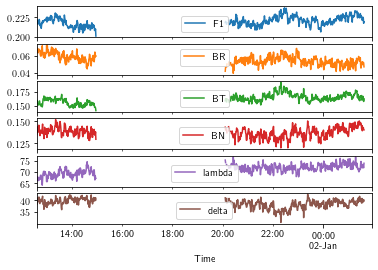

In [13]:
voyager1_data[:1000].plot(subplots=True)

In [14]:
# voyager2_data = date_1d_dict(
#     voyager2_data_raw, "48S", 1
# )  # Resampling with freq means we do not get lines drawn between missing data points on line plots, however it does require some averaging which puts the time points slightly off

In [15]:
# Proportion of missing data
print(voyager1_data.isna().sum() / len(voyager1_data["F1"]))

F1        0.694581
BR        0.694581
BT        0.694581
BN        0.694581
lambda    0.694581
delta     0.694581
dtype: float64


Re-creating Fraternale 2019 Fig. 1(a)

In [16]:
# Resample to daily cadence
voyager1_data_daily = voyager1_data.resample("D").mean()

array([<Axes: xlabel='Time'>, <Axes: xlabel='Time'>,
       <Axes: xlabel='Time'>], dtype=object)

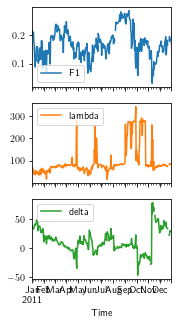

In [17]:
voyager1_data_daily[["F1", "lambda", "delta"]].plot(subplots=True, figsize=(2.5, 5))

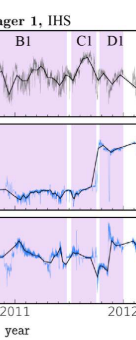

Extracting D1 interval

In [18]:
# Get DOY 276-365 from the raw data
subset = voyager1_data["2011-10-03":"2011-12-31"]["BT"]
del voyager1_data
del voyager1_data_daily
print(len(subset))

160587


In [19]:
subset.isna().sum() / len(subset)

0.7983149320928842

80% data missing

In [20]:
subset_resampled = subset.resample("10min").mean()  # Now only 12,000 long
len(subset_resampled)

12847

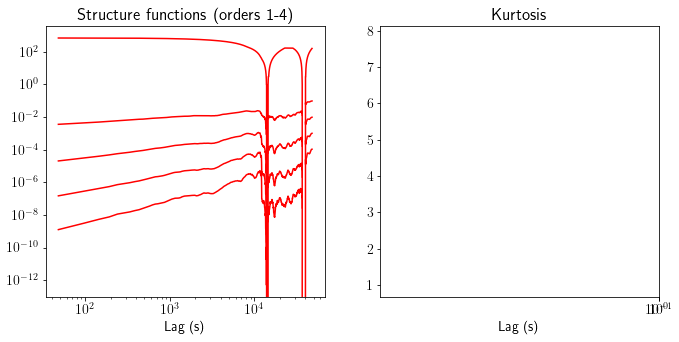

In [181]:
utils.calc_struct_sdk(
    data=subset[:2000],
    freq=1 / 48,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=True,
)

In [73]:
sf = utils.calc_struct_sdk(
    data=subset_resampled,
    freq=1 / 600,
    orders=[1, 2, 3, 4],
    max_lag_fraction=0.5,
    plot=False,
)


In [74]:
# Define the window size for 48 hours in seconds
# Convert index to time index
sf.index = pd.to_timedelta(sf.index, unit="s")

window_size = pd.to_timedelta("48H")

# Compute the rolling maximum for a 48-hour window
sf["rolling_max"] = (
    sf["N"].rolling(window=window_size, min_periods=1, center=True).max()
)

# Compute the threshold
sf["threshold"] = 0.25 * sf["rolling_max"]

# Determine the color based on the threshold
sf["color"] = np.where(sf["N"] < sf["threshold"], "gray", "black")

# Convert the time index to back to seconds
sf.index = sf.index.total_seconds()


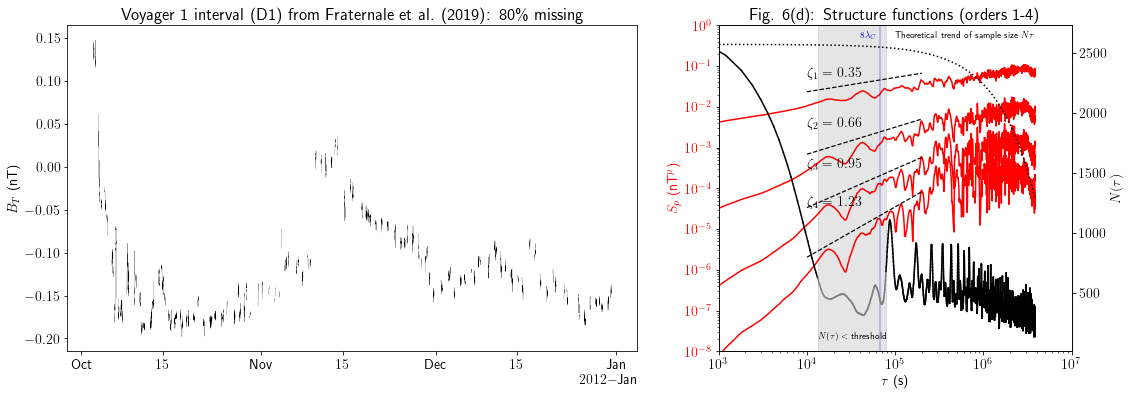

In [185]:
import matplotlib.dates as mdates

# Plot structure functions
xlim = (1e3, 1e7)
ylim_sf = (1e-8, 1e0)
ylim_kurt = (2, 10)

sdk = sf[[2, 4]].copy()
sdk["kurtosis"] = sdk[4].div(sdk[2] ** 2)


fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 5, wspace=0.6)
ax0 = plt.subplot(gs[0, 0:3])

ax1 = plt.subplot(gs[0, 3:])

ax0.plot(subset_resampled, c="black", lw=0.2)
ax0.set_title(r"Voyager 1 interval (D1) from Fraternale et al. (2019): 80\% missing")
ax0.set_ylabel("$B_T$ (nT)")
ax0.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax0.xaxis.get_major_locator())
)

for p in [1, 2, 3, 4]:
    ax1.plot(sf.index, sf[p], c="red", label=f"p={p}")
    qi, xi, pi = utils.fitpowerlaw(sf.index, sf[p].values, 1e4, 2e5)
    ax1.plot(
        xi,
        pi * 2,
        c="black",
        ls="--",
        lw=1.2,
        label="Inertial range power-law fit: $\\alpha_i$ = {0:.2f}".format(qi[0]),
    )

    # Add the slope value as an annotation based on location of the fit
    plt.annotate(
        "$\\zeta_{0} = {1:.2f}$".format(p, qi[0]),
        (xi[0], np.median(pi) * 2),
        fontsize=14,
    )


ax1.semilogx()
ax1.semilogy()
ax1.set(title="Fig. 6(d): Structure functions (orders 1-4)", xlabel="Lag (s)")
if xlim is not None:
    ax1.set_xlim(xlim)
if ylim_sf is not None:
    ax1.set_ylim(ylim_sf)

# plt.show()

ax1.set_xlabel("$\\tau$ (s)")
ax1.set_ylabel("$S_p$ (nT$^p$)", color="red")
ax1.tick_params(axis="y", labelcolor="red")

rectangle_x = sf[sf.color == "gray"].index[0]
rectangle_width = sf[sf.color == "gray"].index[-1] - sf[sf.color == "gray"].index[0]

# Add rectangle to show the range of the power-law fit
ax1.add_patch(
    plt.Rectangle(
        (rectangle_x, 1e-8),
        rectangle_width,
        1,
        color="black",
        alpha=0.1,
    ),
)

ax2 = ax1.twinx()
plt.plot(
    sf.index,
    0.2 * (len(subset_resampled) - (sf.index / 600)),
    color="black",
    ls="dotted",
    label="Theoretical sample size",
)
for i in range(len(sf) - 1):
    ax2.plot(
        sf.index[i : i + 2],
        sf["N"].values[i : i + 2],
        color=sf["color"].values[i],
    )
ax2.set_ylabel("$N(\\tau)$", color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax1.text(rectangle_x, 2e-8, "$N(\\tau)<$ threshold", fontsize=9)
ax1.text(1e5, 5e-1, "Theoretical trend of sample size $N\\tau$", fontsize=9)
# Add vertical line at lag equal to 8 correlation times
ax1.axvline(x=8 * tc, color="black", c="blue", lw=2, alpha=0.2)
ax1.text(rectangle_x * 3, 5e-1, "$8\\lambda_C$", fontsize=9, c="blue")
plt.savefig("plots/background/voyager_sf.png")


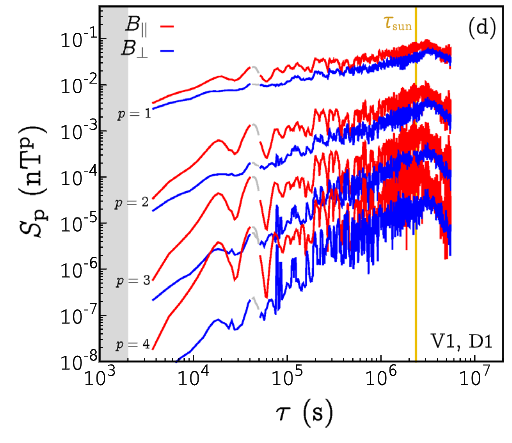
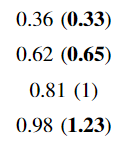

**Thresholding procedure**
"the computation of $S$ is nontrivial for Voyager data sets due to the amount and distribution of missing data." They do not interpolate, but they do account for the variable reduction in sample size at each lag by applying a threshold as to whether they use certain lags to calculate the slopes

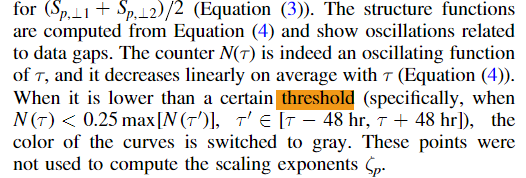

Interestingly, the slopes $\zeta_p$ from my re-sample are closer to the theoretical ESS values!

Focussing on second-order SF ($p=2$). Let's standardise the interval according to my procedure, wanting 8 corr lengths.

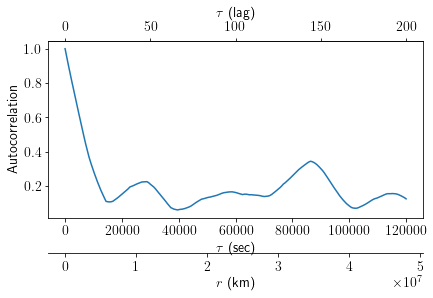

Correlation time = 8449.0s = 2.0 hours


In [189]:
time_lags_lr, r_vec_lr = utils.compute_nd_acf(
    [subset_resampled],
    nlags=200,
    plot=True,
)

tc = utils.compute_outer_scale_exp_trick(time_lags_lr, r_vec_lr, plot=False)
print(f"Correlation time = {np.round(tc)}s = {np.round(tc/3600)} hours")


### The correlation length is about 3 hours. I have been standardising my intervals to have 8 correlation lengths: they have 800. 8 correlation lengths only just gets us to the start of the range over which they perform they power-law fit.

## Standardise

Correlation timescale is about 2 and half hours

In [179]:
tc_n = 10
interval_length = 2000
new_cadence = tc_n * tc / interval_length
print(new_cadence)


42.24533


---

In [ ]:
# IF ANY MISSING, USE THE FOLLOWING CODE TO CHOOSE SUBSET
# Get longest non-missing period, investigate properties (not needed when averaging data)
# a = voyager1_data["F1"].values  # Extract out relevant column from dataframe as array
# m = np.concatenate(([True], np.isnan(a), [True]))  # Mask
# ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1, 2)  # Start-stop limits
# start, stop = ss[(ss[:, 1] - ss[:, 0]).argmax()]  # Get max interval, interval limits
# print(voyager1_data["F1"][[start]])
# print(voyager1_data["F1"][[stop - 1]])



In [ ]:
# # Proportion of missing data
# print(voyager2_data["F1"].isna().sum() / len(voyager2_data["F1"]))

# # IF ANY MISSING, USE THE FOLLOWING CODE TO CHOOSE SUBSET
# # Get longest non-missing period, investigate properties (not needed when averaging data)
# a = voyager2_data["F1"].values  # Extract out relevant column from dataframe as array
# m = np.concatenate(([True], np.isnan(a), [True]))  # Mask
# ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1, 2)  # Start-stop limits
# start, stop = ss[(ss[:, 1] - ss[:, 0]).argmax()]  # Get max interval, interval limits
# print(voyager2_data["F1"][[start]])
# print(voyager2_data["F1"][[stop - 1]])

In [ ]:
# clean = voyager2_data["2017-07-29 20:56:48":"2017-07-30 16:08:00"]
# len(clean)
# # clean.head()

In [ ]:
# voyager1_data[20000:30000].to_csv("data/processed/voyager1_48s.csv")

In [ ]:
# Reproducing Burlaga et al. (2014) Fig. 1
burlaga_subset = voyager1_data["2011":"2013-06"].resample("D").mean()
burlaga_subset["abs(BT)"] = burlaga_subset["BT"].apply(abs)
burlaga_subset[["abs(BT)", "F1"]].plot()
plt.show()

NameError: name 'voyager1_data' is not defined

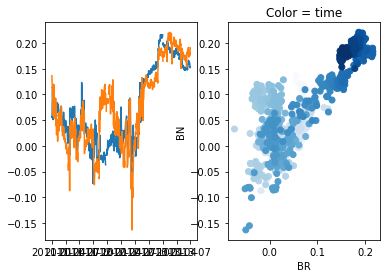

In [ ]:
# See how correlation between the two components changes with time
fig, axs = plt.subplots(1, 2)
axs[0].plot(burlaga_subset[["BR", "BN"]])
axs[1].scatter(
    burlaga_subset["BR"],
    burlaga_subset["BN"],
    c=burlaga_subset.index,
    cmap=plt.cm.Blues,
)
axs[1].set(xlabel="BR", ylabel="BN", title="Color = time")
plt.show()

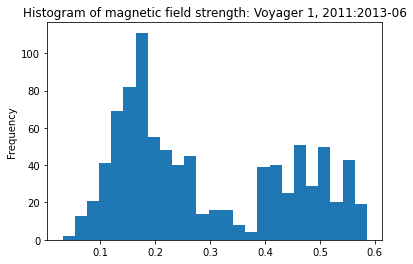

In [ ]:
# Reproducing Burlaga et al. (2014) Fig. 2
burlaga_subset["F1"].plot(
    kind="hist",
    bins=25,
    title="Histogram of magnetic field strength: Voyager 1, 2011:2013-06",
)
# Clear bimodal distribution represents Heliosheath (smaller values) and Interstellar magnetic field (larger values)
plt.show()

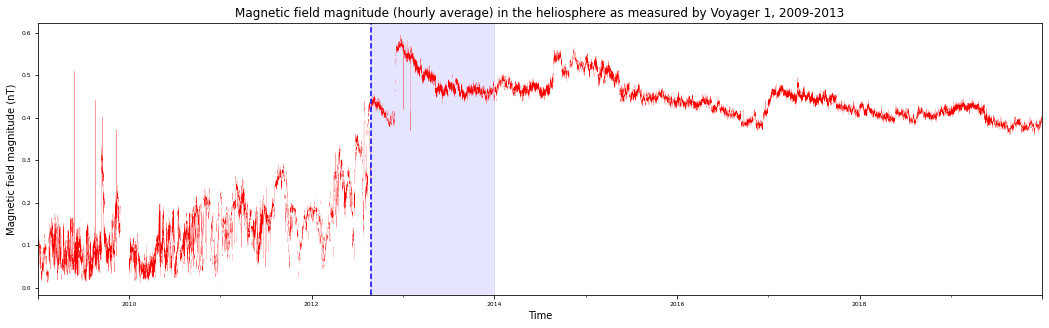

In [ ]:
# Raw data for B with line for heliopause (takes a long time to run)
temp_plot = (
    voyager1_data["F1"]
    .resample("H")
    .mean()
    .plot(
        color="red",
        figsize=(18, 5),
        lw=0.2,
        fontsize=6,
        title="Magnetic field magnitude (hourly average) in the heliosphere as measured by Voyager 1, 2009-2013",
    )
)
temp_plot.set_ylabel("Magnetic field magnitude (nT)")
# Adding a vertical line (e.g. to emphasise a heliospheric boundary)
temp_plot.axvline("2012-08-25", color="blue", linestyle="--")
# Adding a shaded region (e.g. to highlight a heliospheric region)
temp_plot.axvspan("2012-08-25", "2013-12-31", color="blue", alpha=0.1)

## Removing outliers

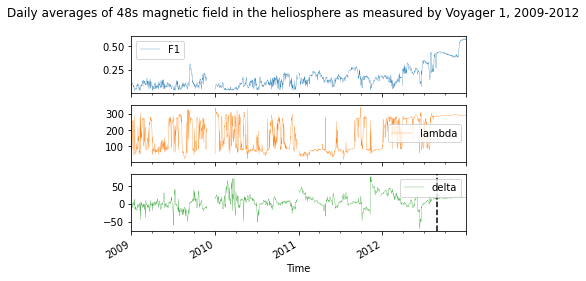

In [ ]:
# Daily smoothed plots of each variable - should replicate Fraternale et al. (2019), Fig. 1
smoothed_data1 = (
    voyager1_data[["F1", "lambda", "delta"]]["2009":"2012"].resample("D").mean()
)
smoothed_data1.plot(
    subplots=True,
    title="Daily averages of 48s magnetic field in the heliosphere as measured by Voyager 1, 2009-2012",
    lw=0.3,
)
plt.axvline("2012-08-25", color="black", linestyle="--")
plt.show()

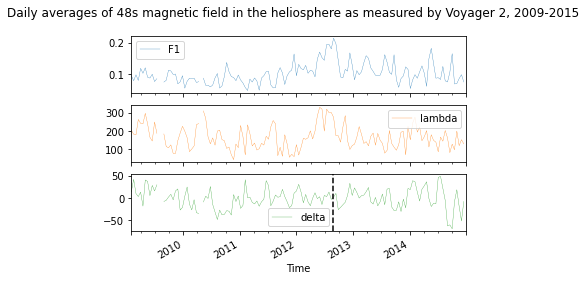

In [ ]:
# Daily smoothed plots of each variable - should replicate Fraternale et al. (2019), Fig. 1
smoothed_data2 = (
    voyager2_data[["F1", "lambda", "delta"]]["2009":"2014"].resample("15D").mean()
)
smoothed_data2.plot(
    subplots=True,
    title="Daily averages of 48s magnetic field in the heliosphere as measured by Voyager 2, 2009-2015",
    lw=0.3,
)
plt.axvline("2012-08-25", color="black", linestyle="--")
plt.show()

In [ ]:
SHS1_V2 = voyager2_data["2009-07-01":"2009-07-3"]
print(SHS1_V2)  # Some missing data

clean_short = voyager1_data["2009-05-10 12:38":"2009-05-10 23:59"]["F1"].dropna()
print(clean_short)

                          F1       BT       BR       BN      lambda      delta
Time                                                                          
2009-07-01 00:00:00      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:00:48      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:01:36      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:02:24      NaN      NaN      NaN      NaN         NaN        NaN
2009-07-01 00:03:12      NaN      NaN      NaN      NaN         NaN        NaN
...                      ...      ...      ...      ...         ...        ...
2009-07-03 23:56:00  0.07554 -0.05825  0.04721 -0.00332  309.023803  -2.518974
2009-07-03 23:56:48  0.06801 -0.05055  0.04212 -0.01717  309.802226 -14.623301
2009-07-03 23:57:36  0.06757 -0.04179  0.04965 -0.01630  319.912953 -13.959225
2009-07-03 23:58:24  0.06124 -0.03953  0.03767 -0.01169  313.619825 -11.004630
2009-07-03 23:59:12  0.07379 -0.05490  0.04436 -0.02

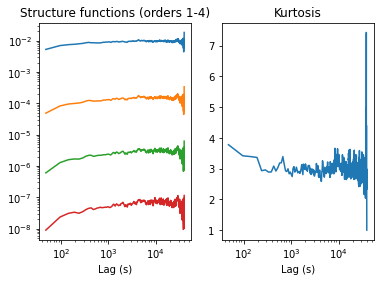

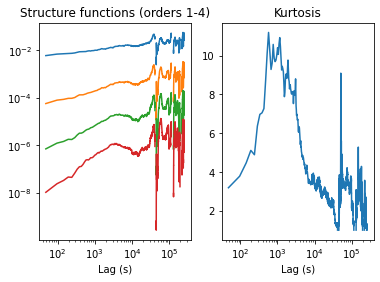

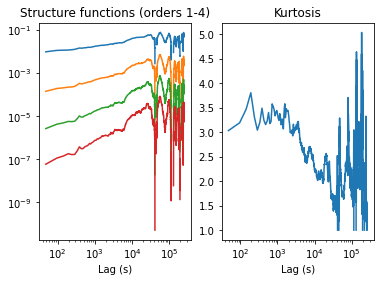

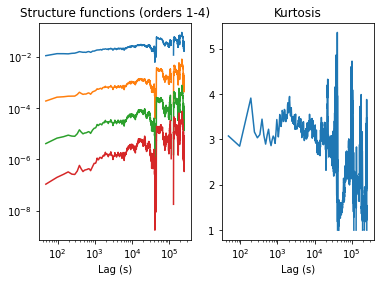

In [ ]:
calc_struct_sdk(clean_short, 1 / 48)  # Period of 12 hours (no missing data)
calc_struct_sdk(SHS1_V2["BR"], 1 / 48)  # Period of three days, including missing data
calc_struct_sdk(SHS1_V2["BT"], 1 / 48)  # Period of three days, including missing data
calc_struct_sdk(SHS1_V2["BN"], 1 / 48)  # Period of three days, including missing data

## Comparing with Tulasi's function

In [ ]:
# Tulasi's kurtosis function


def kurtosis(series, ptlag):
    """
    Routine to perform the Kurtosis on a series at a certain lag
    Input:
        series: the series to take the kurtosis of
        ptlag: the array of lags that represents the number of points to shift the series by
    Output:
        k: the kurtosis of the series
        ptlag: same array as input
    """
    k = []
    ptlag = np.asarray(ptlag).astype(int)
    series = series.copy()
    for i in ptlag:
        temp = (series.shift(-i) - series).copy()
        if (temp.pow(2).mean()) ** 2 == 0 or (temp.pow(4).mean()) == 0:
            coeff = np.NaN
        else:
            coeff = temp.pow(4).mean() / (temp.pow(2).mean() ** 2)
        k += [coeff]
    k = pd.Series(k)

    return k, ptlag

[]

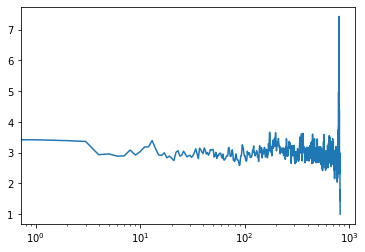

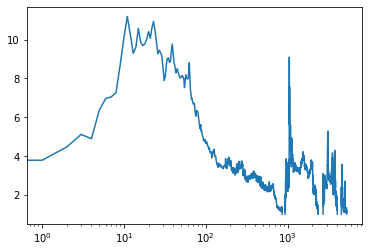

In [ ]:
lags_1 = np.arange(1, len(clean_short))
lags_2 = np.arange(1, len(SHS1_V2))

kurtosis_output, array = kurtosis(clean_short, lags_1)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

kurtosis_output, array = kurtosis(SHS1_V2["BR"], lags_2)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

## Testing on simulated data

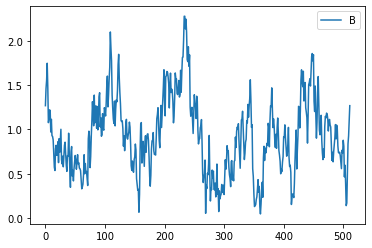

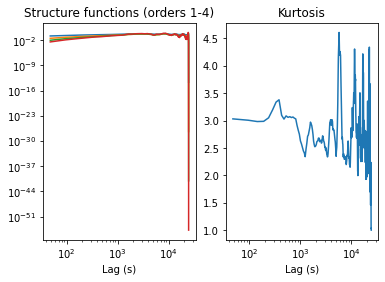

[]

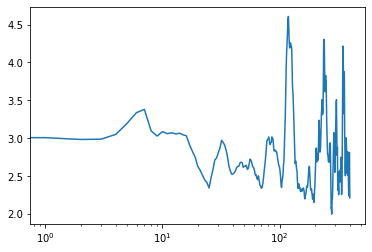

In [ ]:
df = pd.read_csv("Bmag_sim")
df.head()
df.plot()
calc_struct_sdk(df["B"], 1 / 48)

lags = np.arange(1, 400)
kurtosis_output, array = kurtosis(df["B"], lags)
fig, axs = plt.subplots(1)
axs.plot(kurtosis_output)
axs.semilogx()

Looking at data gaps and performing v simple interpolation

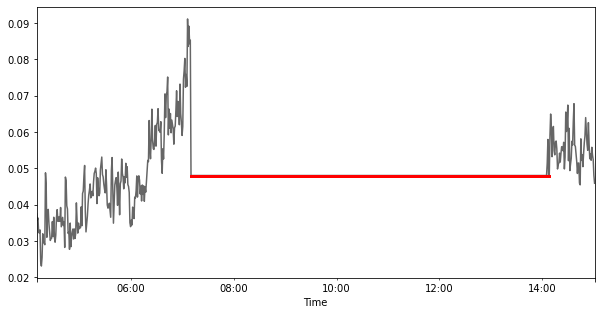

In [ ]:
subset = voyager1_data["F1"]["2009-01-01 04:00":"2009-01-01 15:00"]
missing_values = subset.isna()
# vygr_interp = subset.interpolate('zero')
# Could also replace with median of dataset
vygr_interp = subset.fillna(np.nanmedian(subset))
fig, ax = plt.subplots(figsize=(10, 5))
vygr_interp.plot(color="k", alpha=0.6, ax=ax, legend=False)
vygr_interp[missing_values].plot(ax=ax, color="r", lw=3, legend=False)
plt.show()

## Spectral analysis

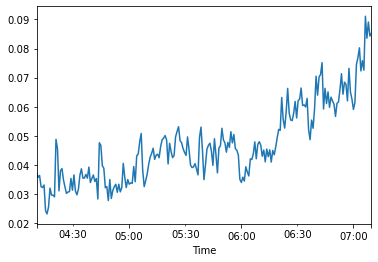

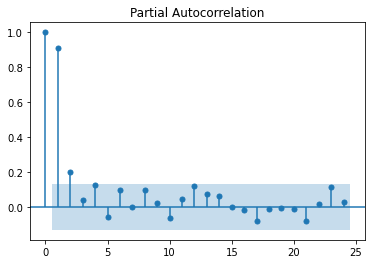

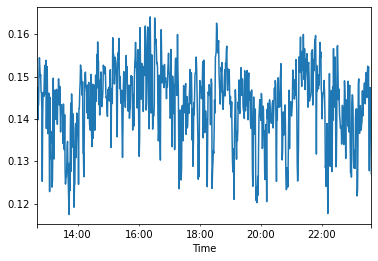

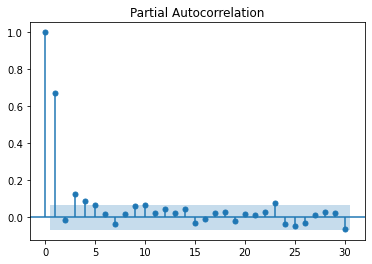

In [ ]:
# Extracting a couple of clean subsets and calculating (partial) autocorrelation

subset = voyager1_data["F1"]["2009-01-01 4:10:24":"2009-01-01 07:09"]
subset.isnull().sum()
subset.plot()
plt.show()

tsaplots.plot_pacf(subset)
plt.show()

subset2 = voyager1_data["2009-05-10 12:38":"2009-05-10 23:59"]["F1"].dropna()
subset2.plot()

tsaplots.plot_pacf(subset2)
plt.show()

In [ ]:
k = np.arange(1, 251) / 10000  # wavenumber for each mode
alpha = -5 / 3  # power law for power spectrum

A_1 = (k ** (-5 / 3)) / 1000000  # amplitudes
A_2 = (k ** (-5 / 6)) / 1000  # amplitudes

plt.plot(k, A)
plt.semilogx()
plt.semilogy()
plt.show()

NameError: name 'A' is not defined

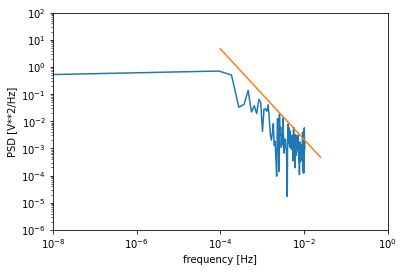

In [ ]:
# Calculating power density spectrum (I think)
# 1/48s = 0.0208Hz is the maximum frequency

f, Pxx_den = signal.periodogram(subset, 0.0208)  # See also: signal.welch
plt.semilogy(f, Pxx_den)
plt.plot(k, A_1)
plt.semilogx()
plt.xlim([1e-8, 1e0])
plt.ylim([1e-6, 1e2])
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.show()

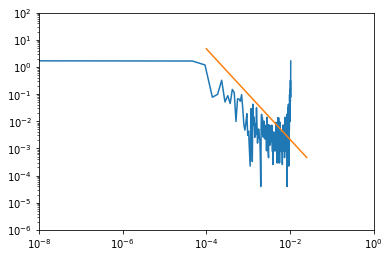

In [ ]:
# Power spectrum (here) = square of absolute value of discrete Fourier transform
sampling_rate = 1 / 48

fourier_transform = np.fft.fft(subset)  # Compute Fourier transform of data
magnitudes = abs(fourier_transform)
power_spectrum = np.square(magnitudes)

frequency = np.linspace(0, sampling_rate / 2, len(power_spectrum))

plt.plot(frequency, power_spectrum)
plt.plot(k, A_1)
plt.semilogx()
plt.semilogy()
plt.xlim([1e-8, 1e0])
plt.ylim([1e-6, 1e2])
plt.show()

# Importing daily data on proton temperature and density from ASC file


In [ ]:
data = read_asc_ts(
    "voyager/voyager1_daily.asc",
    [0, 1, 2, 14, 15],
    {
        "Year": 999.999,
        "Day": 999.999,
        "Hour": 999.999,
        "Proton density": 99.99999,
        "Proton temperature": 9999999,
    },
    "D",
)

The unique hours in this dataset are: [0]


In [ ]:
data.head()

Proton density  Proton temperature
Time                                          
1977-01-01             NaN                 NaN
1977-01-02             NaN                 NaN
1977-01-03             NaN                 NaN
1977-01-04             NaN                 NaN
1977-01-05             NaN                 NaN

In [ ]:
print(data[data["Proton density"].notnull()])
print(data[data["Proton temperature"].notnull()])

            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
...                    ...                 ...
1980-11-21         0.13605             14242.0
1980-11-22         0.22841             11759.0
1980-12-22         0.00254              4168.0
1980-12-30         0.00334             27008.0
1980-12-31         0.00440             58516.0

[1116 rows x 2 columns]
            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
...                    ...         

<AxesSubplot:xlabel='Time'>

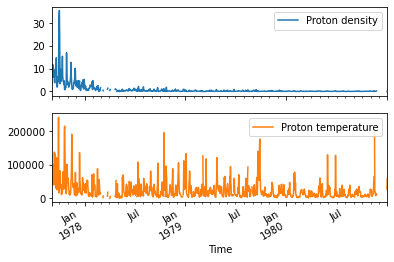

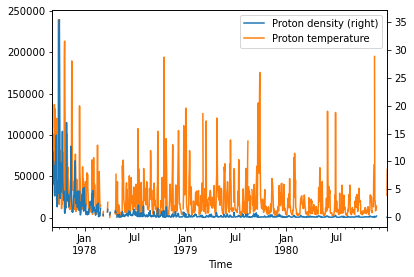

In [ ]:
# Revising the range of the data
data = data["1977-09-07":"1980-12-31"]
data.plot(subplots=True)
data.plot(secondary_y="Proton density")

In [ ]:
data.isnull().sum().div(len(data))  # % missing data

Proton density        0.079208
Proton temperature    0.079208
dtype: float64

In [ ]:
data.describe()

Proton density  Proton temperature
count     1116.000000         1116.000000
mean         0.842078        24275.247312
std          2.501148        27757.026962
min          0.002080          410.000000
25%          0.066733         7687.250000
50%          0.158105        15233.500000
75%          0.462703        30067.250000
max         35.379840       239761.000000

In [ ]:
raw_corr = data["Proton density"].corr(data["Proton temperature"])
pct_chg_corr = (
    data["Proton density"].pct_change().corr(data["Proton temperature"].pct_change())
)
print("Correlation of proton density and proton temperature %4.2f" % (raw_corr))
print(
    "Correlation of proton density and proton temperature percent changes %4.2f"
    % (pct_chg_corr)
)

Correlation of proton density and proton temperature 0.22
Correlation of proton density and proton temperature percent changes 0.32


<AxesSubplot:ylabel='Density'>

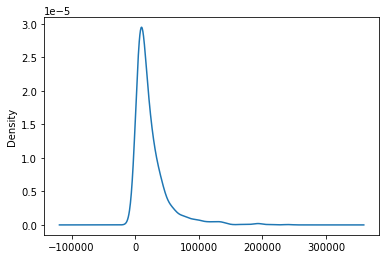

In [ ]:
data["Proton temperature"].plot(kind="density")

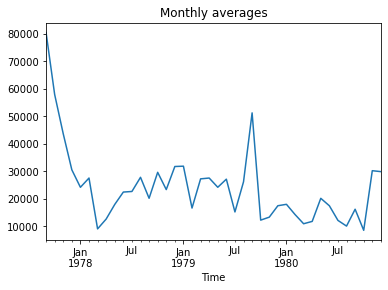

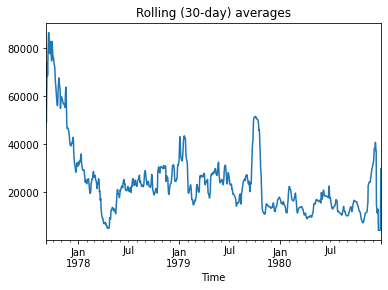

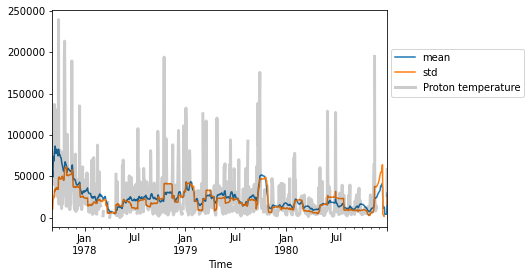

In [ ]:
temp = data["Proton temperature"]

monthly = temp.resample("M").mean()
monthly.plot(title="Monthly averages")
plt.show()
monthly = temp.rolling(window="30D").mean()
monthly.plot(title="Rolling (30-day) averages")

rolling_stats = temp.rolling(window="30D").agg(["mean", "std"])
# stats = temp.join(rolling_stats)
# stats[['Proton temperature', 'max', 'std']].plot(subplots = True, title = 'Daily voyager temp with rolling (30-day) mean and standard deviation')

ax = rolling_stats.plot()
temp.plot(ax=ax, color="k", alpha=0.2, lw=3)
ax.legend(loc=(1.01, 0.6))
plt.show()

## Calculating lag

            Proton density  Proton temperature
Time                                          
1977-09-07         6.50961             56486.0
1977-09-08        11.77037             41582.0
1977-09-09         8.06071             79608.0
1977-09-10         6.19061             92300.0
1977-09-11         8.68447            100807.0
            Proton density  Proton temperature
Time                                          
1977-09-08         5.26076            -14904.0
1977-09-09        -3.70966             38026.0
1977-09-10        -1.87010             12692.0
1977-09-11         2.49386              8507.0
1977-09-12        -2.46050            -60513.0


array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>],
      dtype=object)

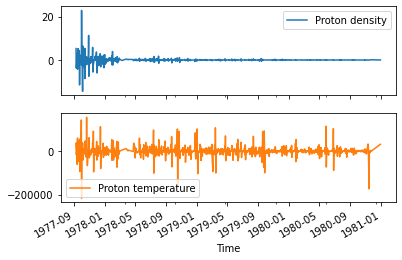

In [ ]:
lag_1 = data.diff().dropna()
print(data.head())
print(lag_1.head())
lag_1[["Proton density", "Proton temperature"]].plot(subplots=True)

<AxesSubplot:xlabel='Proton temperature', ylabel='Density'>

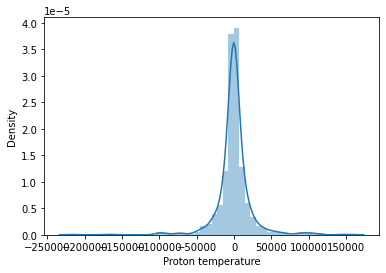

In [ ]:
sns.distplot(lag_1["Proton temperature"])

## Calculation autocorrelation

In [ ]:
autocorrelation = data["Proton temperature"].autocorr()
print("The autocorrelation of proton temperature is %4.2f" % (autocorrelation))

autocorrelation = data["Proton density"].autocorr()
print("The autocorrelation of proton density is %4.2f" % (autocorrelation))

The autocorrelation of proton temperature is 0.62
The autocorrelation of proton density is 0.86


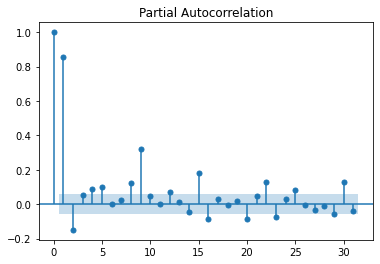

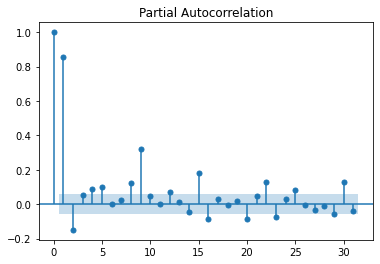

In [ ]:
plot_pacf(data["Proton density"].dropna())  # Don't know why it creates